In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import optimize
import random

In [41]:
T = pd.read_csv('/Users/siyangwei/Documents/ANES_datasets/anes_timeseries_cdf_csv_20220916/anes_timeseries_cdf_csv_20220916.csv',
                low_memory=False)

In [42]:
T['VCF0101'] = pd.to_numeric(T['VCF0101'],errors='coerce',downcast='integer')
T = T[T['VCF0101']<=80]   # restrict age <= 80
T['VCF0004'] = pd.to_numeric(T['VCF0004'],errors='coerce',downcast='integer')
year = T['VCF0004']       
yr = set(year)      # extract survey years
age = T['VCF0101']       # extract respondent age
M = pd.concat([year,age],axis=1,join='inner')

In [43]:
# filter thermometer questions
coln = len(T.columns)  # number of columns(variables)
questions = {}
for i in range(2,coln):
    values = set(T.iloc[:,i])
    values = [str(x) for x in values]
    avalues = [x for x in values if x.strip()]
    try:
        ivalues = [int(x) for x in avalues]
    except ValueError:
        # print(T.columns[i],'contains non integer value')
        continue
    if all([x in range(0,100) for x in ivalues]) and any([x>50 for x in ivalues]):
        questions[T.columns[i]] = ivalues
        # print(T.columns[i],':',ivalues)

In [44]:
removekeys = ['VCF0124','VCF0125','VCF0126b','VCF0126c','VCF0127a','VCF0150','VCF0153b','VCF0153c','VCF0154a',
             'VCF0317','VCF0321','VCF0323','VCF0375b','VCF0381b','VCF0387b','VCF0393b',
             'VCF0404','VCF0408','VCF0410','VCF0476b','VCF0476d','VCF0482b','VCF0482d',
             'VCF0488b','VCF0488d','VCF0494b','VCF0494d','VCF0735','VCF0749','VCF0875',
              'VCF0900','VCF0902','VCF0976','VCF0983','VCF0987','VCF0989','VCF0996',
             'VCF1000','VCF1002','VCF1006','VCF1007','VCF1008','VCF1015','VCF1016',
             'VCF1021b','VCF1027b','VCF1033b','VCF1039b',
             'VCF9001','VCF9055','VCF9067','VCF9123','VCF9124']
for key in removekeys:
    del questions[key]

In [45]:
keylist = list(questions)
keylistlong = []
for k in keylist:
    col = T[k].replace(' ','-1').astype('int')
    yearsur = year[(col <= 99) & (col >= 0)] # survey years
    yrsur = set(yearsur)
    if len(yrsur) >= 10:
        keylistlong.append(k)
        print(k)

VCF0204
VCF0205
VCF0206
VCF0207
VCF0209
VCF0210
VCF0211
VCF0212
VCF0213
VCF0217
VCF0218
VCF0220
VCF0223
VCF0224
VCF0225
VCF0228
VCF0229
VCF0232
VCF0234
VCF0414
VCF0424
VCF0425
VCF0426
VCF0427
VCF0428
VCF0429
VCF0443
VCF0471
VCF0801
VCF0901a
VCF9004
VCF9005


In [46]:
# import real US matrix
Wim = pd.read_excel('/Users/siyangwei/Documents/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx',
                   sheet_name = 53, header = None)
Wim = Wim.to_numpy()

/Users/siyangwei/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [47]:
# preprocess interaction matrix
N = 16
WUS = np.copy(Wim)
# the real US matrix (scale entries by maximum row sum)
#rowsumax = max(np.sum(Wim, axis=1))
#WUS = WUS/rowsumax

# constant matrix W
Wc = np.ones([N,N])

# symmetrized US matrix
# scale WUS such that the first row and col both sums to 1
Wnml = np.copy(WUS)
#sc = sum(WUS[1:N,0])/(1-Wnml[0,0])
#Wnml[1:N,0] = WUS[1:N,0]/sc
Wsym = (Wnml + np.transpose(Wnml))/2

In [48]:
# matrix used for fit
W = np.copy(Wsym)

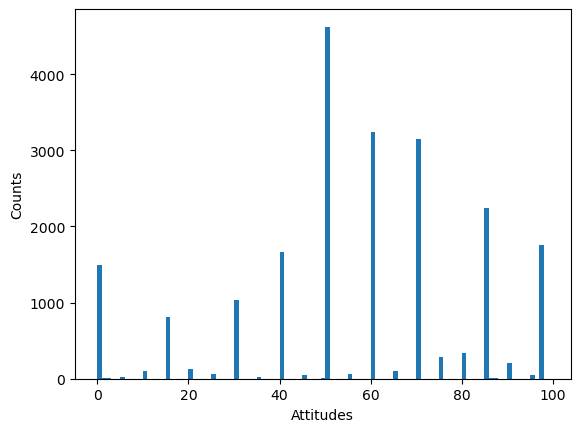

In [49]:
# Analyze a question
varname = 'VCF0225'           
var = T[varname].replace(' ','-1').astype('int')
D = M.join(var,how='inner')
# 1970 type of this question, 0009: 0, 0010: 1, 0011: 2
weightvar = 'VCF0009z'
weight = T[weightvar]
Dw = D.join(weight, how = 'inner')
# plot a 3-peak-distribution
df = Dw[(var >=0) & (var<98)]

plt.hist(df[varname], weights=df[weightvar], bins=range(0, 100, 1))
plt.xlabel('Attitudes')
plt.ylabel('Counts')
#plt.title('Histogram of Attitudes towards LGBTQ+')
#plt.savefig('therdataweightedplots/' + '3peak'+varname+'.jpg',  bbox_inches = "tight")
plt.show()

In [50]:
I = np.zeros([len(yr),7,13])  # 3d array, year, type and type percentage, 13 age groups
J = np.zeros([len(yr),7])  # 2d array, year, type and type percentage
yr = list(yr)
J[:,0] = yr

for j in range(13): # 13 age groups
    
    # extract data for age group j
    maskj = (age > 5*(j+3)) & (age <= 5*(j+4))
    Mag = Dw[maskj == True]
    
    # count for each year
    I[:,0,j] = yr
    for i in range(len(yr)):
        maskyr = (Mag['VCF0004'] == yr[i])
        Magyr = Mag[maskyr == True]
        # weighted number of negative attitude in year i, age group j
        I[i,1,j] = Magyr.loc[(Magyr[varname] >= 0) & (Magyr[varname] < 50), weightvar].sum()
        #I[i,1,j] = sum((Magyr[varname] >= 0) & (Magyr[varname] < 50))
        # neutral
        #I[i,2,j] = sum(Magyr[varname] == 50)
        I[i,2,j] = Magyr.loc[Magyr[varname] == 50, weightvar].sum()
        # positive
        I[i,3,j] = Magyr.loc[(Magyr[varname] > 50) & (Magyr[varname] < 98), weightvar].sum()
        #I[i,3,j] = sum((Magyr[varname] > 50) & (Magyr[varname] < 98))
        # number of opinion 1 in year i, all age groups
        J[i,1] += I[i,1,j]
        J[i,2] += I[i,2,j]
        J[i,3] += I[i,3,j]

# delete the year without data for I and J
J2 = J[:,[1,2,3]]
J = J[~np.all(J2 == 0, axis = 1)]
t = J[:,0]
In = np.zeros([len(t),7,13])
for k in range(13):
    ind = np.isin(I[:,0,k],t)
    In[:,:,k] = I[ind,:,k]

np.seterr(invalid='ignore') # ignore 0/0 error, will return NaN
# compute opinion 1/ population of each year
In[:,4,:] = In[:,1,:]/np.sum(In[:,[1,2,3],:],1)
In[:,5,:] = In[:,2,:]/np.sum(In[:,[1,2,3],:],1)
In[:,6,:] = In[:,3,:]/np.sum(In[:,[1,2,3],:],1)

J[:,4] = J[:,1]/np.sum(J[:,[1,2,3]],1)
J[:,5] = J[:,2]/np.sum(J[:,[1,2,3]],1)
J[:,6] = J[:,3]/np.sum(J[:,[1,2,3]],1)

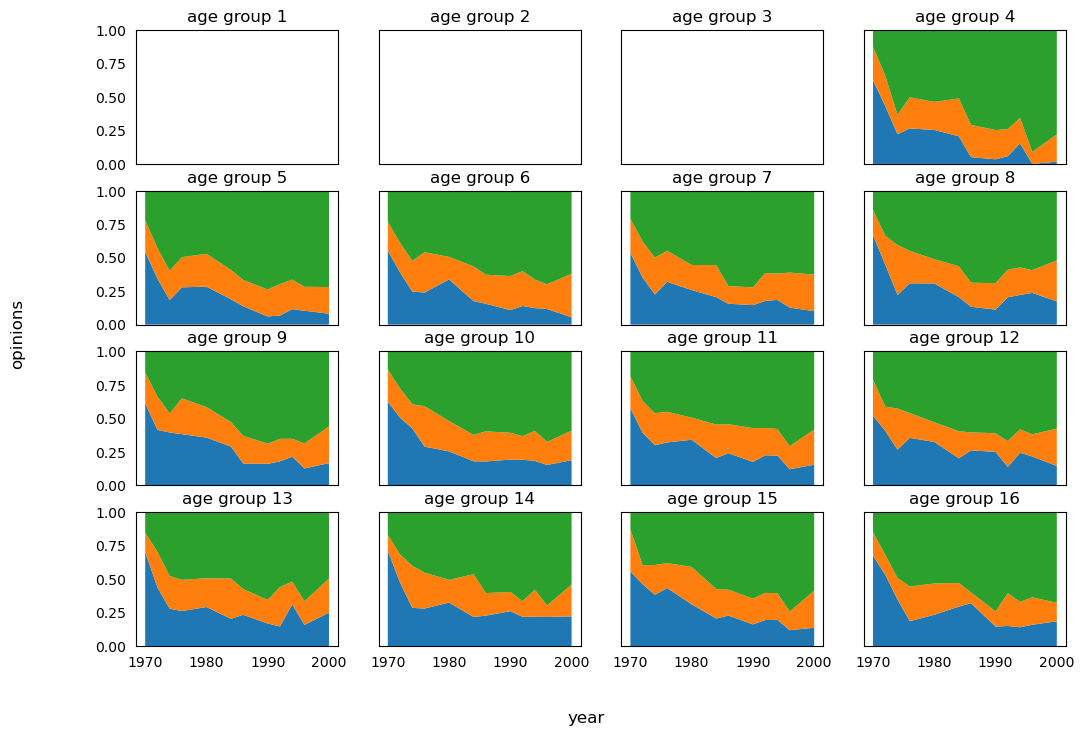

In [51]:
# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].stackplot(t[kindex],np.vstack([In[kindex,4,k-3],In[kindex,5,k-3],In[kindex,6,k-3]]),labels=['negative','neutral','positive'])
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
for ax in axs.flat:
    ax.label_outer()

fig.supxlabel('year')
fig.supylabel('opinions')
#plt.savefig('therdataweightedplots/' + 'stacked'+varname+'.jpg')
plt.show()

In [52]:
# Initial Conditions
tmax = int((t[-1]-t[0]+5)//5 + 1) # ceil division, time gap = age group diff = 5 years
taxis = np.arange(0,tmax)*5 + t[0]
# use the same initial condition as in dataset
pneg = np.zeros([N,tmax])
pneu = np.zeros([N,tmax])
ppos = np.zeros([N,tmax])

# deal with NaN values: replace NaN with average
# intead of replacing with average, replace NaN with the next available value in this year
for i in range(3,N):
    if In[0,4,i-3] != In[0,4,i-3]:
        pneg[i,0] = next((x for x in In[0,4,:] if x == x))
        pneu[i,0] = next((x for x in In[0,5,:] if x == x))
        ppos[i,0] = next((x for x in In[0,6,:] if x == x))
    else:
        pneg[i,0] = In[0,4,i-3]
        pneu[i,0] = In[0,5,i-3]
        ppos[i,0] = In[0,6,i-3]
        
pneg[0:3,0] = In[0,4,2:5] # IC for age 0-15: assume the same as IC for age 25-40
pneu[0:3,0] = In[0,5,2:5]
ppos[0:3,0] = In[0,6,2:5]

In [53]:
# tab = [['Model','Minimum SSE','Parameters','AIC score'],['Constant,symmetric'],['Constant,asymmetric'],
#        ['Linear,symmetric,coordinated'],['Linear,symmetric,uncoordinated'],
#        ['Linear,asymmetric,coordinated'],['Linear,asymmetric,uncoordinated']]

In [54]:
# simulation given be and ga
def sim(bet,gam):
    
    p1 = np.zeros([N,tmax])
    p2 = np.zeros([N,tmax])
    p3 = np.zeros([N,tmax])
    p1[:,0] = pneg[:,0]
    p2[:,0] = pneu[:,0]
    p3[:,0] = ppos[:,0]
    for iter in range(tmax-1):
        # the first age group
        p1[0,iter+1] = np.dot(W[0,:],p1[:,iter])/sum(W[0,:])     # negative
        p2[0,iter+1] = np.dot(W[0,:],p2[:,iter])/sum(W[0,:])     # neutral
        p3[0,iter+1] = np.dot(W[0,:],p3[:,iter])/sum(W[0,:])     # positive
        for gp in range(1,N):
                
            p1[gp,iter+1] = np.dot(p1[gp-1,iter],(1-bet[gp]*np.dot(W[gp,:],(1-p1[:,iter])))) \
            + np.dot(p2[gp-1,iter],gam[gp]*np.dot(W[gp,:],p1[:,iter]))
            p2[gp,iter+1] = np.dot(p2[gp-1,iter],(1-bet[gp]*np.dot(W[gp,:],p3[:,iter])-gam[gp]*np.dot(W[gp,:],p1[:,iter]))) \
            + p1[gp-1,iter]*bet[gp]*np.dot(W[gp,:],(1-p1[:,iter])) + p3[gp-1,iter]*gam[gp]*np.dot(W[gp,:],(1-p3[:,iter]))
            p3[gp,iter+1] = p3[gp-1,iter]*(1-gam[gp]*np.dot(W[gp,:],1-p3[:,iter])) \
            + p2[gp-1,iter]*bet[gp]*np.dot(W[gp,:],p3[:,iter])
            
            # sanity check
            
    return p1,p2,p3

In [55]:
# sum squared error for constant, symmetric model, parameters c,a(numbers)
def Jcs(param):  
    c = param[0]
    a = param[1]
    sse = 0
    be = (c+a)*np.ones(N)
    ga = (c-a)*np.ones(N)
    pneg,pneu,ppos = sim(be,ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [56]:
# backtracking line search
def BTLS(fun, w, dw, c = 0.01, gam = 0.5):
    fw = fun(w)
    dwnorm = np.linalg.norm(dw)
    d = -dw * 1e-5 / dwnorm     # descent direction
    deltaf = -c * 1e-5 * dwnorm
    newf = fun(w + d)
    t = 1
    while newf > fw + t * deltaf:
        t = gam * t
        newf = fun(w + t * d)
    return t, d

In [57]:
def grad_descent(fun,w_init,model,eps=1e-6, maxIter=100):
    w = w_init
    dw = np.ones(w_init.shape)
    W = []
    costs = []
    n_iter = 0
    
    while n_iter < maxIter:
        # gradient of fun w.r.t. w
        dw = optimize.approx_fprime(w,fun,epsilon=1.4901161193847656e-08)
        if np.linalg.norm(dw) < 1e-4:
            break
        
        # adaptively choose step size
        lr, d = BTLS(fun, w, dw)
        w = w + lr * d
        cost = fun(w)
        
        # sanity check:
        if model == 'cs':
            be = (w[0]+w[1])*np.ones(N)
            ga = (w[0]-w[1])*np.ones(N)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
        
        if model == 'cas':
            bel = (w[0]+w[2])*np.ones(N)
            gal = (w[0]-w[2])*np.ones(N)
            ber = (w[1]+w[3])*np.ones(N)
            gar = (w[1]-w[3])*np.ones(N)
            if max(bel)>1 or min(bel)<0 or max(gal)>1 or min(gal)<0 or max(ber)>1 or min(ber)<0 or max(gar)>1 or min(gar)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lsc':   # linear, symmetric, coordinated
            be = (w[0]+w[1])*np.ones(N) + w[2]*np.arange(0,N)
            ga = (w[0]-w[1])*np.ones(N) - w[2]*np.arange(0,N)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lsu':     #linear, symmetric, uncoordinated
            be = w[0]*np.ones(N) + w[2] * np.arange(0,N)
            ga = w[1]*np.ones(N) + w[3] * np.arange(0,N)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lac':      # linear, asymmetric, coordinated
            bel = (w[0]+w[1])*np.ones(N) + w[2]*np.arange(0,N)
            gal = (w[0]-w[1])*np.ones(N) - w[2]*np.arange(0,N)
            ber = (w[3]+w[4])*np.ones(N) + w[5]*np.arange(0,N)
            gar = (w[3]-w[4])*np.ones(N) - w[5]*np.arange(0,N)
            if max(bel)>1 or min(bel)<0 or max(gal)>1 or min(gal)<0 or max(ber)>1 or min(ber)<0 or max(gar)>1 or min(gar)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lau':
            bel = w[0]*np.ones(N) + w[4]*np.arange(0,N)
            gal = w[1]*np.ones(N) + w[5]*np.arange(0,N)
            ber = w[2]*np.ones(N) + w[6]*np.arange(0,N)
            gar = w[3]*np.ones(N) + w[7]*np.arange(0,N)
            if max(bel)>1 or min(bel)<0 or max(gal)>1 or min(gal)<0 or max(ber)>1 or min(ber)<0 or max(gar)>1 or min(gar)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
#         if n_iter >= maxIter:
#             break
        
    return W, costs

In [58]:
# randomly choose ten initial guess
i = 0
paramrec = np.zeros((2,100))
costrec = np.zeros(100)
while i < 100:
    init = np.zeros(2)
    init[0] = random.uniform(0,0.1)
    init[1] = random.uniform(-0.1,0.1)
    be = (init[0]+init[1])*np.ones(N)
    ga = (init[0]-init[1])*np.ones(N)
    safe = True
    for j in range(1, N):
        if be[j]*sum(W[j,:])>1 or ga[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and 0 < sum(init) < 1 and 0 < init[0]-init[1] < 1:
        params, costs = grad_descent(Jcs,init,'cs')
        if len(params) == 0:
            continue
        par = params[-1]
        be = (par[0] + par[1])*np.ones(N)
        ga = (par[0] - par[1])*np.ones(N)
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 10 == 0:
                print(i, min(costrec[:i+1]))
            i += 1

ssecs = min(costrec)
besti = np.argmin(costrec)
csopt = paramrec[:,besti]
print('minimum SSE:',round(ssecs,5))
print('parameters:',np.around(csopt,decimals = 5))

0 81.19971837588297
10 17.844503846415396
20 17.844503846415396
30 15.80210807357485
40 15.80210807357485
50 15.80210807357485
60 15.80210807357485
70 15.80210807357485
80 15.80210807357485
90 15.80210807357485
minimum SSE: 15.80211
parameters: [0.01492 0.01492]


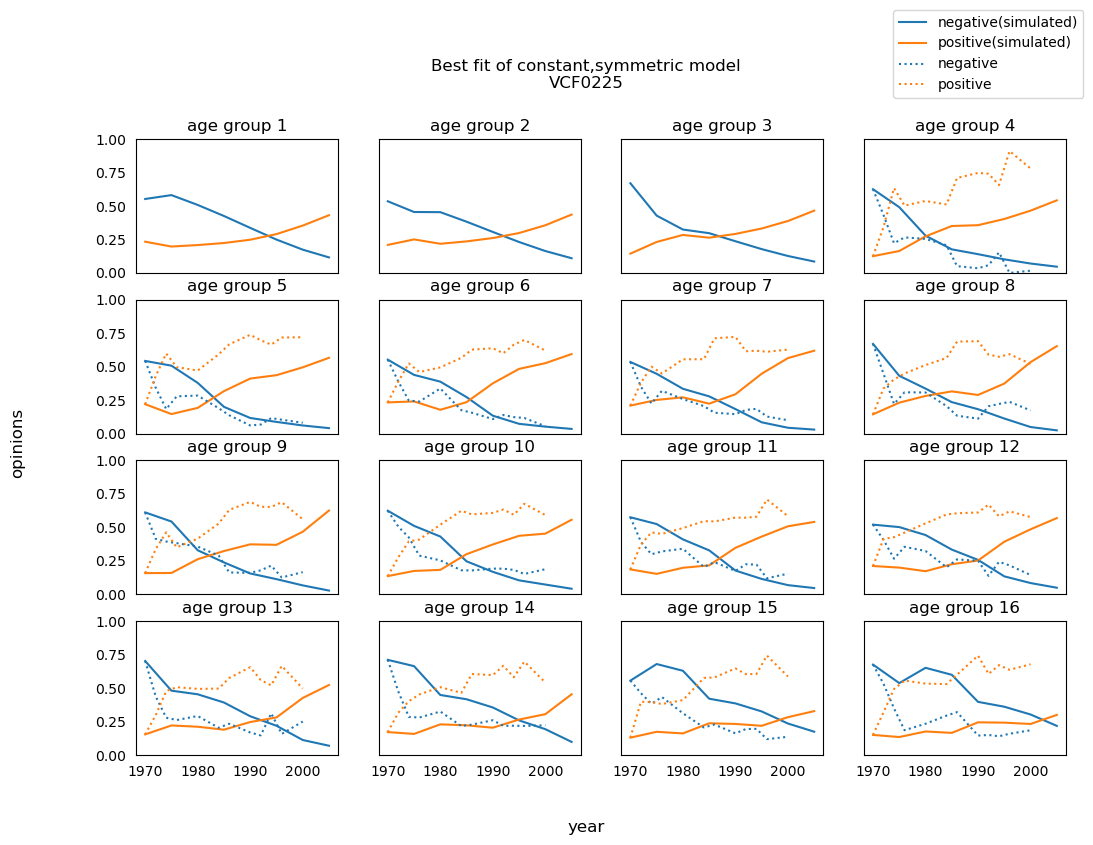

In [59]:
# visualization
be = (csopt[0]+csopt[1])*np.ones(N)
ga = (csopt[0]-csopt[1])*np.ones(N)
for j in range(1, N):
    if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
        print('Warning')
pneg,pneu,ppos = sim(be,ga)
# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of constant,symmetric model\n' + varname)
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('thermodelweightedfits/'+'case1fit'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [60]:
# simulations given asymmetric parameters: 
# bel(-1 to 0),ber(0 to 1),gal(0 to -1),gar(1 to 0)
def simasym(beL,beR,gaL,gaR):
    p1 = np.zeros([N,tmax])
    p2 = np.zeros([N,tmax])
    p3 = np.zeros([N,tmax])
    p1[:,0] = pneg[:,0]
    p2[:,0] = pneu[:,0]
    p3[:,0] = ppos[:,0]
    for iter in range(tmax-1):
        # the first age group
        p1[0,iter+1] = np.dot(W[0,:],p1[:,iter])/sum(W[0,:])
        p2[0,iter+1] = np.dot(W[0,:],p2[:,iter])/sum(W[0,:])
        p3[0,iter+1] = np.dot(W[0,:],p3[:,iter])/sum(W[0,:])
        for gp in range(1,N):
            p1[gp,iter+1] = p1[gp-1,iter]*(1-beL[gp]*np.dot(W[gp,:],(1-p1[:,iter]))) \
            + p2[gp-1,iter]*gaL[gp]*np.dot(W[gp,:],p1[:,iter])
            p2[gp,iter+1] = p2[gp-1,iter]*(1-beR[gp]*np.dot(W[gp,:],p3[:,iter])-gaL[gp]*np.dot(W[gp,:],p1[:,iter])) \
            + p1[gp-1,iter]*beL[gp]*np.dot(W[gp,:],(1-p1[:,iter])) + p3[gp-1,iter]*gaR[gp]*np.dot(W[gp,:],(1-p3[:,iter]))
            p3[gp,iter+1] = p3[gp-1,iter]*(1-gaR[gp]*np.dot(W[gp,:],1-p3[:,iter])) \
            + p2[gp-1,iter]*beR[gp]*np.dot(W[gp,:],p3[:,iter])
        
            
    return p1,p2,p3

In [61]:
# sse for constant, asymmetric model
# parameters cl,cr,al,ar
def Jcas(param):
    sse = 0
    cl = param[0]
    cr = param[1]
    al = param[2]
    ar = param[3]
    bel = (cl+al)*np.ones(N)
    gal = (cl-al)*np.ones(N)
    ber = (cr+ar)*np.ones(N)
    gar = (cr-ar)*np.ones(N)
    pneg,pneu,ppos = simasym(bel,ber,gal,gar)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [62]:
# randomly choose ten initial guess
i = 0
nt = 500
paramrec = np.zeros((4,nt))
costrec = np.zeros(nt)
while i < nt or min(costrec) > ssecs:
    init = np.zeros(4)
    if i == 0:
        init[0], init[1] = csopt[0], csopt[0]
        init[2], init[3] = csopt[1], csopt[1]
        params, costs = grad_descent(Jcas,init,'cas')
        if len(params) == 0:
            costrec[0] = ssecs
            paramrec[:,0] = init
            i += 1
            continue
        casopt = params[-1]
        BEL = (casopt[0]+casopt[2])*np.ones(N)
        GAL = (casopt[0]-casopt[2])*np.ones(N)
        BER = (casopt[1]+casopt[3])*np.ones(N)
        GAR = (casopt[1]-casopt[3])*np.ones(N)
        safe = True
        for j in range(1, N):
            if BEL[j]*sum(W[j,:]) > 1 or BER[j]*sum(W[j, :])>1 or GAL[j]*sum(W[j,:]) > 1 or GAR[j]*sum(W[j, :])>1:
                safe = False
                break
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:, 0] = params[-1]
            costrec[0] = costs[-1]
        i += 1
    else:
        init[0], init[1] = random.uniform(0,0.1), random.uniform(0,0.1)
        init[2], init[3] = random.uniform(-0.1,0.1), random.uniform(-0.1,0.1)
        safe = True
        belinit = (init[0]+init[2])*np.ones(N)
        galinit = (init[0]-init[2])*np.ones(N)
        berinit = (init[1]+init[3])*np.ones(N)
        garinit = (init[1]-init[3])*np.ones(N)
        for j in range(1, N):
            if belinit[j]*sum(W[j,:]) > 1 or berinit[j]*sum(W[j,:]) > 1 or galinit[j]*sum(W[j,:]) > 1 or garinit[j]*sum(W[j,:]) > 1:
                safe = False
                break
        if safe and 0 <= init[0]+init[2] <= 1 and 0 <= init[0]-init[2] <= 1 and 0 <= init[1]+init[3] <= 1 and 0 <= init[1]-init[3] <= 1:
            params, costs = grad_descent(Jcas,init,'cas')
            if len(params) == 0:
                continue
            casopt = params[-1]
            BEL = (casopt[0]+casopt[2])*np.ones(N)
            GAL = (casopt[0]-casopt[2])*np.ones(N)
            BER = (casopt[1]+casopt[3])*np.ones(N)
            GAR = (casopt[1]-casopt[3])*np.ones(N)
            safe = True
            for j in range(1, N):
                if BEL[j]*sum(W[j,:]) > 1 or BER[j]*sum(W[j, :])>1 or GAL[j]*sum(W[j,:]) > 1 or GAR[j]*sum(W[j, :])>1:
                    safe = False
                    break
            if len(costs) >= 1 and min(costs) > 0 and safe:
                if i < nt:
                    paramrec[:,i] = params[-1]
                    costrec[i] = costs[-1]
                else:
                    paramrec = np.append(paramrec, params[-1].reshape(4,1), axis = 1)
                    costrec = np.append(costrec, costs[-1])
                if i % 100 == 0:
                    print(i, min(costrec[:i+1]))
                i += 1

if costrec[0] > 0:
    ssecas = min(costrec)
    besti = np.argmin(costrec)
    casopt = paramrec[:,besti]
else:
    ssecas = min(costrec[1:])
    besti = np.argmin(costrec[1:])
    casopt = paramrec[:,besti]
print('minimum SSE:',round(ssecas,5))
print('parameters:',np.around(casopt,decimals=5))

100 15.80210807357485
200 13.60631369970834
300 13.60631369970834
400 13.60631369970834
minimum SSE: 13.60631
parameters: [0.0155  0.02078 0.01529 0.01976]


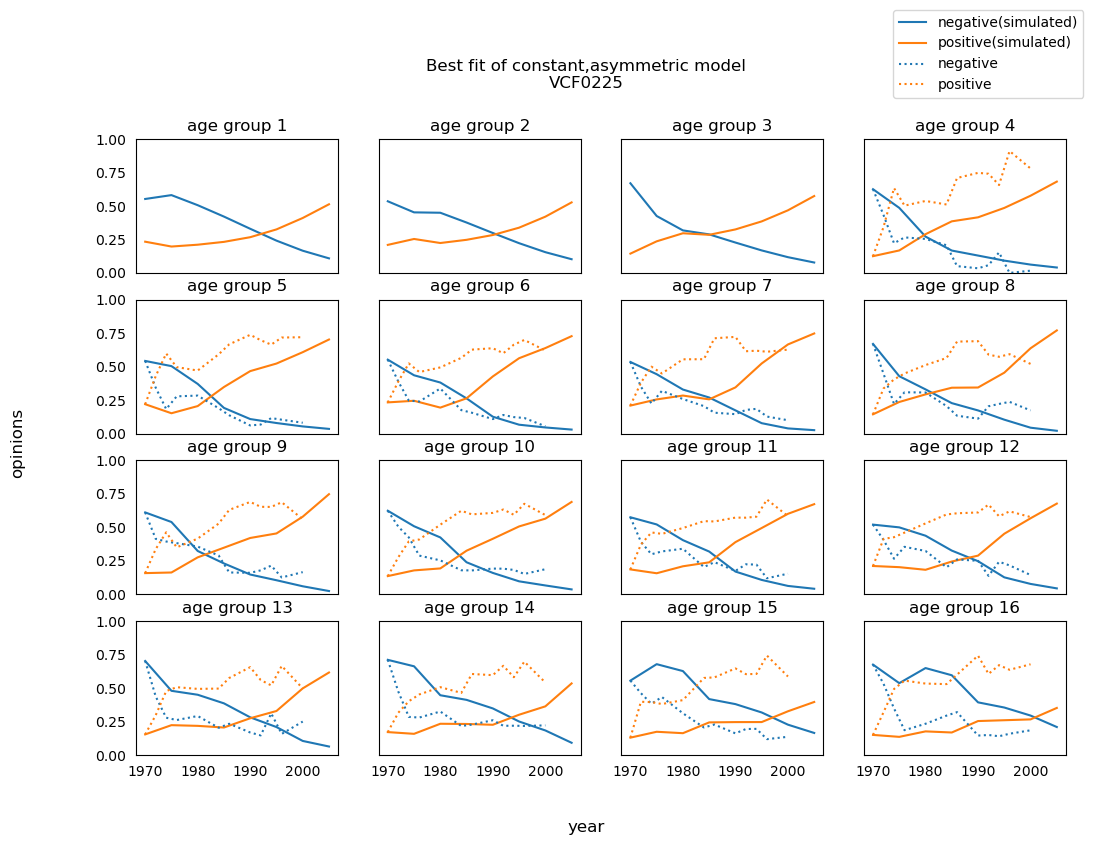

In [63]:
# Visualization
# find the optimal c and a, plot the comparison
BEL = (casopt[0]+casopt[2])*np.ones(N)
GAL = (casopt[0]-casopt[2])*np.ones(N)
BER = (casopt[1]+casopt[3])*np.ones(N)
GAR = (casopt[1]-casopt[3])*np.ones(N)
for j in range(1, N):
    if BEL[j]*sum(W[j,:]) > 1 or BER[j]*sum(W[j, :])>1 or GAL[j]*sum(W[j,:]) > 1 or GAR[j]*sum(W[j, :])>1:
        print('Warning')
pneg,pneu,ppos = simasym(BEL,BER,GAL,GAR)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of constant,asymmetric model\n' + varname)
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('thermodelweightedfits/'+'casfit'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [64]:
# linear, symmetric, coordinated
# 3 parameters c, a, g
def Jlsc(param):
    sse = 0
    c = param[0]
    a = param[1]
    g = param[2]
    be = (c+a)*np.ones(N) + g*np.arange(0,16)
    ga = (c-a)*np.ones(N) - g*np.arange(0,16)
    pneg,pneu,ppos = sim(be,ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [65]:
# randomly choose ten initial guess
i = 0
nt = 500
paramrec = np.zeros((3,nt))
costrec = np.zeros(nt)
costrec[0] = ssecs
while i < nt or min(costrec) > ssecs:
    if i == 0:
        init = np.zeros(3)
        init[0], init[1] = csopt[0], csopt[1]
    else:
        init = np.zeros(3)
        init[0] = random.uniform(0,0.1)
        init[1] = random.uniform(-0.1,0.1)
        init[2] = random.uniform(-0.001,0.001)
    beinit = (init[0]+init[1])*np.ones(N) + init[2]*np.arange(0,N)
    gainit = (init[0]-init[1])*np.ones(N) - init[2]*np.arange(0,N)
    safe = True
    for j in range(1, N):
        if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        if i < nt:
            paramrec[:,i] = init
            costrec[i] = Jlsc(init)
        else:
            paramrec = np.append(paramrec, init.reshape(3,1), axis = 1)
            costrec = np.append(costrec, Jlsc(init))
        params, costs = grad_descent(Jlsc,init,'lsc')
        if len(params) == 0:
            if i == 0:
                i += 1
            continue
        lscopt = params[-1]
        be = (lscopt[0]+lscopt[1])*np.ones(N) + lscopt[2]*np.arange(0,16)
        ga = (lscopt[0]-lscopt[1])*np.ones(N) - lscopt[2]*np.arange(0,16)
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
                break
        if len(costs) >= 1 and min(costs) > 0 and safe:
            if i < nt:
                paramrec[:,i] = params[-1]
                costrec[i] = costs[-1]
            else:
                paramrec = np.append(paramrec, params[-1].reshape(3,1), axis = 1)
                costrec = np.append(costrec, costs[-1])
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

sselsc = min(costrec)
besti = np.argmin(costrec)
lscopt = paramrec[:,besti]
print('minimum SSE:',round(sselsc,5))
print('parameters:',np.around(lscopt,decimals=5))

100 11.66796606487145
200 11.66796606487145
300 11.66796606487145
400 11.66796606487145
minimum SSE: 11.66797
parameters: [0.02204 0.01993 0.00014]


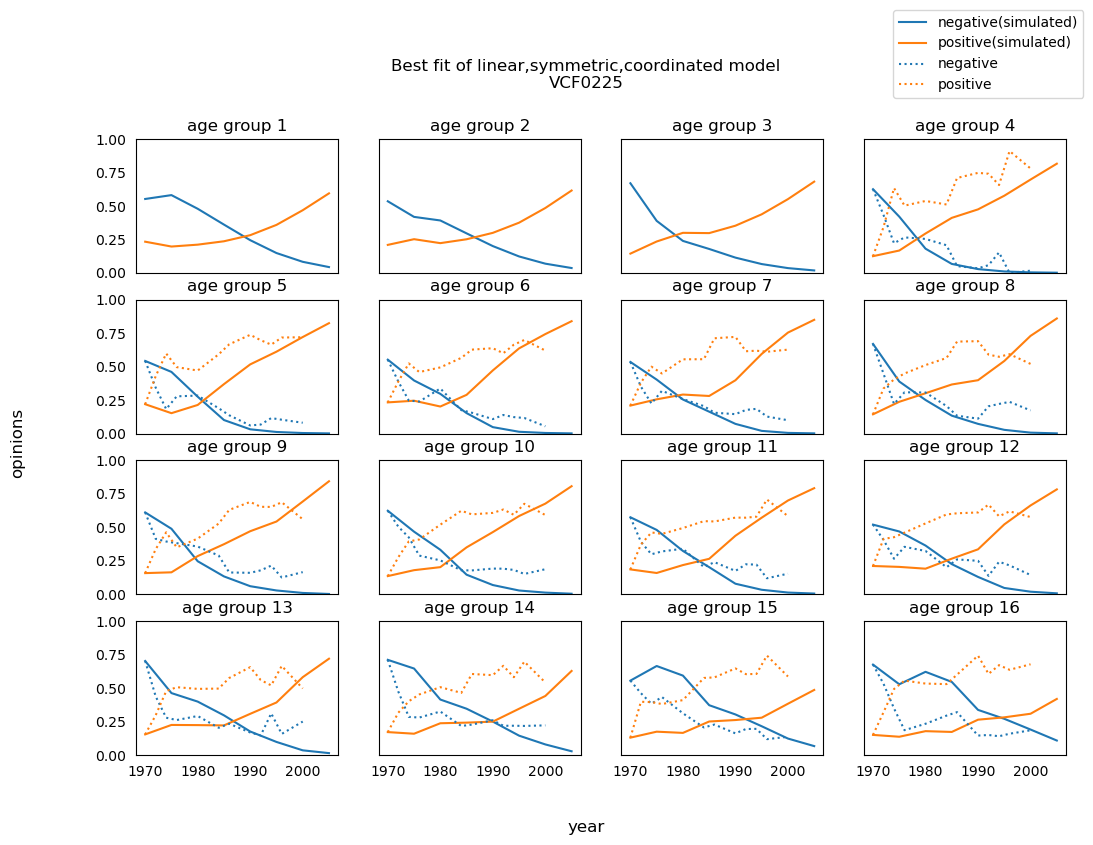

In [66]:
# Visualization
# find the optimal c and a, plot the comparison
be = (lscopt[0]+lscopt[1])*np.ones(N) + lscopt[2]*np.arange(0,16)
ga = (lscopt[0]-lscopt[1])*np.ones(N) - lscopt[2]*np.arange(0,16)
for j in range(1, N):
    if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
        print('Warning')
pneg,pneu,ppos = sim(be,ga)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,symmetric,coordinated model\n' + varname)
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('thermodelweightedfits/'+'lscfit'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [67]:
# linear, symmetric, uncoordinated
# 4 parameters: c1, g1, c2, g2
def Jlsu(param):
    sse = 0
    c1 = param[0]
    g1 = param[2]
    c2 = param[1]
    g2 = param[3]
    be = c1*np.ones(N) + g1*np.arange(0,16)
    ga = c2*np.ones(N) + g2*np.arange(0,16)
    pneg,pneu,ppos = sim(be,ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [68]:
## randomly choose ten initial guess
i = 0
paramrec = np.zeros((4,500))
costrec = np.zeros(500)
costrec[0] = float('inf')
while i < 500 or min(costrec) > sselsc:
    init = np.zeros(4)
    if i == 0:
        init[0] = lscopt[0] + lscopt[1]
        init[1] = lscopt[0] - lscopt[1]
        init[2], init[3] = lscopt[2], -lscopt[2]
    else:
        init[0], init[1] = random.uniform(0,0.1), random.uniform(0,0.1)
        init[2], init[3] = random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
    beinit = init[0]*np.ones(N) + init[2]*np.arange(0,N)
    gainit = init[1]*np.ones(N) + init[3]*np.arange(0,N)
    safe = True
    for j in range(1, N):
        if beinit[j]*sum(W[j,:])>1 or gainit[j]*sum(W[j,:])>1:
            safe = False
            break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        if i < 500:
            paramrec[:,i] = init
            costrec[i] = Jlsu(init)
        else:
            paramrec = np.append(paramrec, init.reshape(4,1), axis = 1)
            costrec = np.append(costrec, Jlsu(init))
        params, costs = grad_descent(Jlsu,init,'lsu')
        if len(params) == 0:
            if i == 0:
                i += 1
            continue
        lsuopt = params[-1]
        be = lsuopt[0]*np.ones(N) + lsuopt[2]*np.arange(0,16)
        ga = lsuopt[1]*np.ones(N) + lsuopt[3]*np.arange(0,16)
        safe = True
        for j in range(1, N):
            if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
                safe = False
                break
        if len(costs) >= 1 and min(costs) > 0 and safe:
            if i < 500:
                paramrec[:,i] = params[-1]
                costrec[i] = costs[-1]
            else:
                paramrec = np.append(paramrec, params[-1].reshape(4,1), axis = 1)
                costrec = np.append(costrec, costs[-1])
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

sselsu = min(costrec)
besti = np.argmin(costrec)
lsuopt = paramrec[:,besti]
print('minimum SSE:',round(sselsu,5))
print('parameters:',np.around(lsuopt,decimals=5))

100 11.66796606487145
200 11.075646254699967
300 11.075646254699967
400 11.075646254699967
minimum SSE: 11.07565
parameters: [3.96e-02 2.14e-03 1.18e-03 8.00e-05]


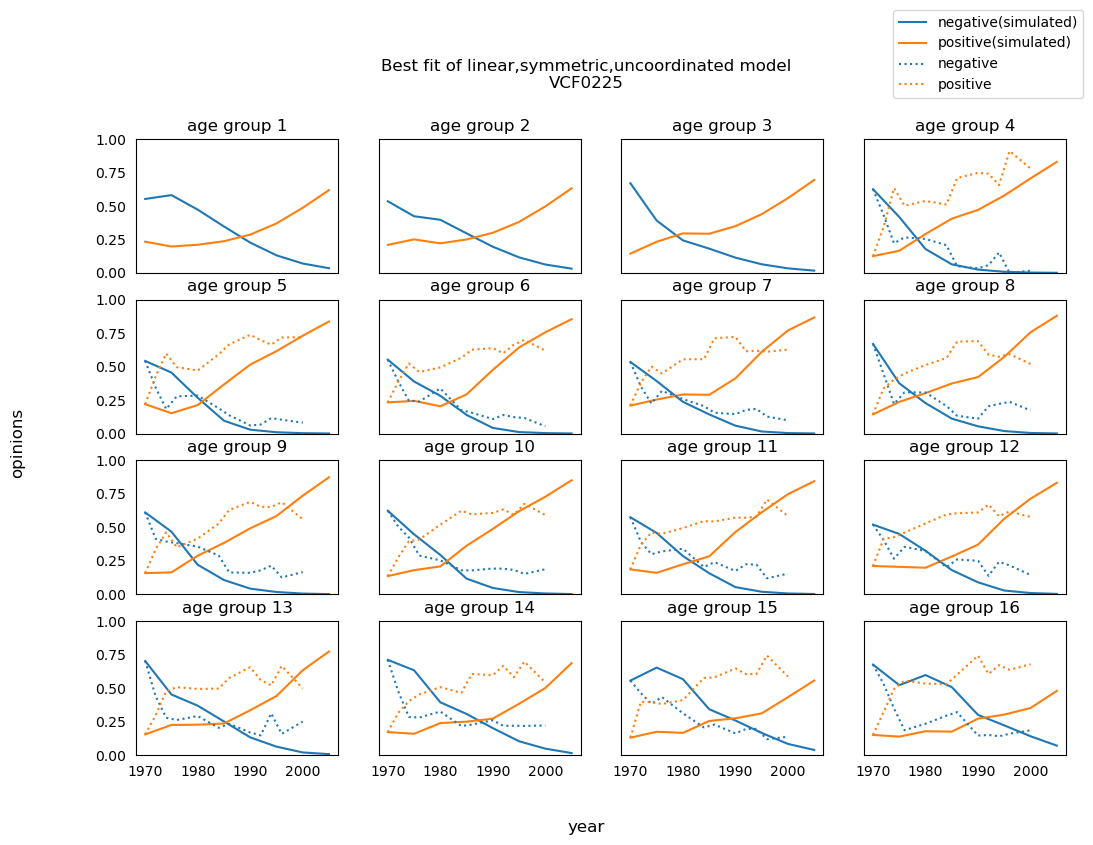

In [69]:
# Visualization
# find the optimal c and a, plot the comparison
be = lsuopt[0]*np.ones(N) + lsuopt[2]*np.arange(0,16)
ga = lsuopt[1]*np.ones(N) + lsuopt[3]*np.arange(0,16)
for j in range(1, N):
    if be[j]*sum(W[j,:]) > 1 or ga[j]*sum(W[j, :])>1:
        print('Warning')
pneg,pneu,ppos = sim(be,ga)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,symmetric,uncoordinated model\n' + varname)
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('thermodelweightedfits/'+'lsufit'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [70]:
# sse for linear, asymmetric, coordinated model
# parameters cl,al,gl,cr,ar,gr
def Jlac(param):
    sse = 0
    cl = param[0]
    al = param[1]
    gl = param[2]
    cr = param[3]
    ar = param[4]
    gr = param[5]
    bel = (cl+al)*np.ones(N) + gl * np.arange(0,N)
    gal = (cl-al)*np.ones(N) - gl * np.arange(0,N)
    ber = (cr+ar)*np.ones(N) + gr * np.arange(0,N)
    gar = (cr-ar)*np.ones(N) - gr * np.arange(0,N)
    pneg,pneu,ppos = simasym(bel,ber,gal,gar)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [71]:
# randomly choose ten initial guess
i = 0
nt = 1000
paramrec = np.zeros((6,nt))
costrec = np.zeros(nt)
costrec[0] = ssecas
while i < nt:
    init = np.zeros(6)
    if i == 0:
        init[0], init[1], init[2] = casopt[0], casopt[2], 0
        init[3], init[4], init[5] = casopt[1], casopt[3], 0
    elif i == 1:
        init[0], init[1], init[2] = lscopt[0], lscopt[1], lscopt[2]
        init[3], init[4], init[5] = lscopt[0], lscopt[1], lscopt[2]
    else:
        init[0], init[3] = random.uniform(0,0.1), random.uniform(0,0.1)
        init[1], init[4] = random.uniform(-0.1,0.1), random.uniform(-0.1,0.1)
        init[2], init[5] = random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
    belinit = (init[0]+init[1])*np.ones(N) + init[2]*np.arange(0,N)
    galinit = (init[0]-init[1])*np.ones(N) - init[2]*np.arange(0,N)
    berinit = (init[3]+init[4])*np.ones(N) + init[5]*np.arange(0,N)
    garinit = (init[3]-init[4])*np.ones(N) - init[5]*np.arange(0,N)
    safe = True
    for j in range(1, N):
        if belinit[j]*sum(W[j,:]) > 1 or berinit[j]*sum(W[j,:]) > 1 or galinit[j]*sum(W[j,:]) > 1 or garinit[j]*sum(W[j,:]) > 1:
            safe = False
    if safe and min(belinit) >= 0 and max(belinit) <= 1 and min(galinit) >= 0 and max(galinit) <= 1 and min(berinit) >= 0 and max(berinit) <= 1 and min(garinit) >= 0 and max(garinit) <= 1:
        if i < nt:
            paramrec[:,i] = init
            costrec[i] = Jlac(init)
        else:
            paramrec = np.append(paramrec, init.reshape(6,1), axis = 1)
            costrec = np.append(costrec, Jlac(init))
        params, costs = grad_descent(Jlac,init,'lac')
        if len(params) == 0:
            i += 1
            continue
        lacopt = params[-1]
        BEL = (lacopt[0]+lacopt[1])*np.ones(N) + lacopt[2]*np.arange(0,N)
        GAL = (lacopt[0]-lacopt[1])*np.ones(N) - lacopt[2]*np.arange(0,N)
        BER = (lacopt[3]+lacopt[4])*np.ones(N) + lacopt[5]*np.arange(0,N)
        GAR = (lacopt[3]-lacopt[4])*np.ones(N) - lacopt[5]*np.arange(0,N)
        safe = True
        for j in range(1, N):
            if BEL[j]*sum(W[j,:]) > 1 or BER[j]*sum(W[j, :])>1 or GAL[j]*sum(W[j,:]) > 1 or GAR[j]*sum(W[j, :])>1:
                safe = False
                break
        if len(costs) >= 1 and costs[-1] > 0 and safe:
            if i < nt:
                paramrec[:,i] = params[-1]
                costrec[i] = costs[-1]
            else:
                paramrec = np.append(paramrec, params[-1].reshape(6,1), axis = 1)
                costrec = np.append(costrec, costs[-1])
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0 or i == 1:
            i += 1

sselac = min(costrec)
besti = np.argmin(costrec)
lacopt = paramrec[:,besti]
print('minimum SSE:',round(sselac,5))
print('parameters:',np.around(lacopt,decimals=5))

0 13.451847206274744
100 11.66796606487145
200 11.66796606487145
300 11.66796606487145
400 11.66796606487145
500 11.66796606487145
600 11.66796606487145
700 11.66796606487145
800 11.66796606487145
900 11.66796606487145
minimum SSE: 11.66797
parameters: [0.02204 0.01993 0.00014 0.02204 0.01993 0.00014]


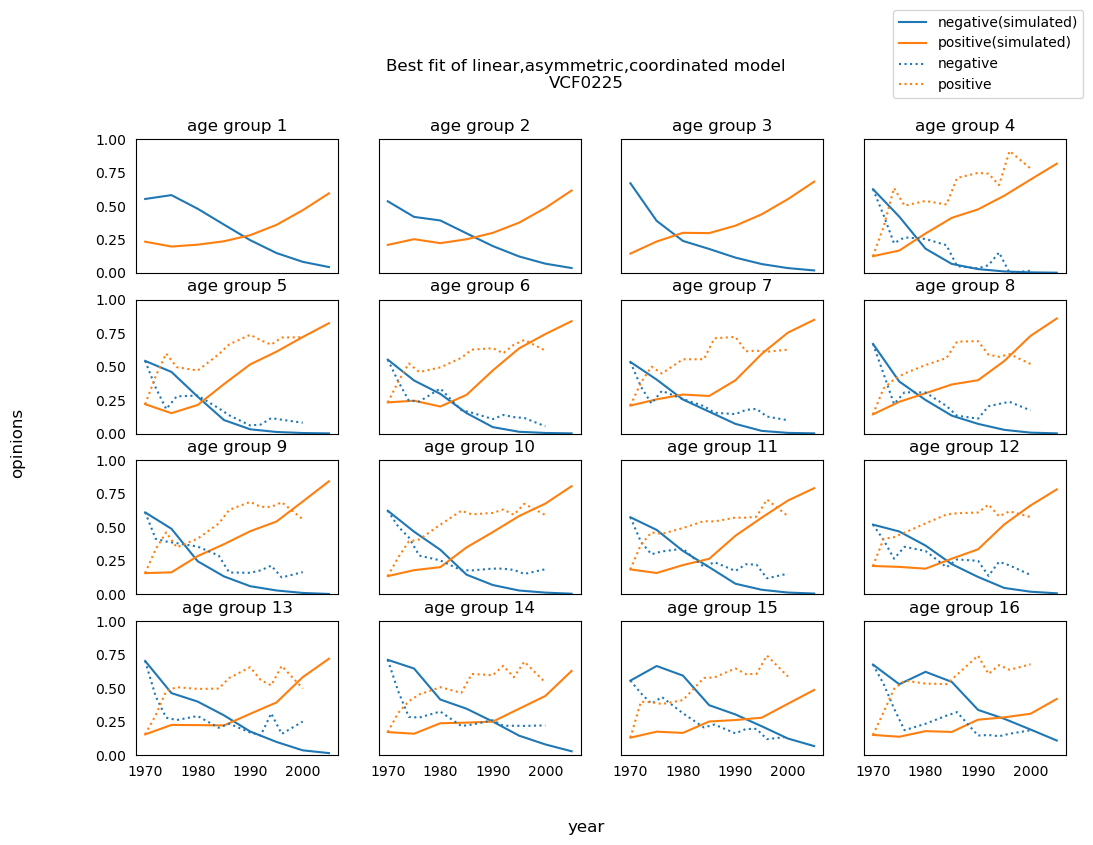

In [72]:
# Visualization
# find the optimal c and a, plot the comparison
BEL = (lacopt[0]+lacopt[1])*np.ones(N) + lacopt[2]*np.arange(0,N)
GAL = (lacopt[0]-lacopt[1])*np.ones(N) - lacopt[2]*np.arange(0,N)
BER = (lacopt[3]+lacopt[4])*np.ones(N) + lacopt[5]*np.arange(0,N)
GAR = (lacopt[3]-lacopt[4])*np.ones(N) - lacopt[5]*np.arange(0,N)
for j in range(1, N):
    if BEL[j]*sum(W[j,:]) > 1 or BER[j]*sum(W[j, :])>1 or GAL[j]*sum(W[j,:]) > 1 or GAR[j]*sum(W[j, :])>1:
        print('Warning')
pneg,pneu,ppos = simasym(BEL,BER,GAL,GAR)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,asymmetric,coordinated model\n'+varname)
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('thermodelweightedfits/'+'lacfit'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [73]:
# sse for linear, asymmetric, uncoordinated model
# 8 parameters c1,c2,c3,c4,g1,g2,g3,g4
def Jlau(param):
    sse = 0
    c1, c2, c3, c4 = param[0], param[1], param[2], param[3]
    g1, g2, g3, g4 = param[4], param[5], param[6], param[7]
    bel = c1*np.ones(N) + g1 * np.arange(0,N)
    gal = c2*np.ones(N) + g2 * np.arange(0,N)
    ber = c3*np.ones(N) + g3 * np.arange(0,N)
    gar = c4*np.ones(N) + g4 * np.arange(0,N)
    pneg,pneu,ppos = simasym(bel,ber,gal,gar)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [79]:
# randomly choose ten initial guess
i = 0
nt = 1000
paramrec = np.zeros((8,nt))
costrec = np.zeros(nt)
costrec[0] = sselac
while i < nt or min(costrec) > sselac:
    init = np.zeros(8)
    if i == 0:
        init[0] = lacopt[0] + lacopt[1]
        init[1] = lacopt[0] - lacopt[1]
        init[2] = lacopt[3] + lacopt[4]
        init[3] = lacopt[3] - lacopt[4]
        init[4], init[5] = lacopt[2], -lacopt[2]
        init[6], init[7] = lacopt[5], -lacopt[5]
    elif i == 1:
        init[0], init[2] = lsuopt[0], lsuopt[0]
        init[1], init[3] = lsuopt[1], lsuopt[1]
        init[4], init[6] = lsuopt[2], lsuopt[2]
        init[5], init[7] = lsuopt[3], lsuopt[3]
        costrec[1] = sselsu
    else:
        init[0], init[1], init[2], init[3] = random.uniform(0,0.1), random.uniform(0,0.1), random.uniform(0,0.1), random.uniform(0,0.1)
        init[4], init[5], init[6], init[7] = random.uniform(-0.001,0.001), random.uniform(-0.001,0.001), random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
    belinit = init[0]*np.ones(N) + init[4]*np.arange(0,N)
    galinit = init[1]*np.ones(N) + init[5]*np.arange(0,N)
    berinit = init[2]*np.ones(N) + init[6]*np.arange(0,N)
    garinit = init[3]*np.ones(N) + init[7]*np.arange(0,N)
    safe = True
    for j in range(1, N):
        if belinit[j]*sum(W[j,:]) > 1 or berinit[j]*sum(W[j,:]) > 1 or galinit[j]*sum(W[j,:]) > 1 or garinit[j]*sum(W[j,:]) > 1:
            safe = False
    if safe and min(belinit) > 0 and max(belinit) < 1 and min(galinit) > 0 and max(galinit) < 1 and min(berinit) > 0 and max(berinit) < 1 and min(garinit) > 0 and max(garinit) < 1:
        if i < nt:
            paramrec[:,i] = init
            costrec[i] = Jlau(init)
        else:
            paramrec = np.append(paramrec, init.reshape(8, 1), axis = 1)
            costrec = np.append(Jlau(init))
        params, costs = grad_descent(Jlau,init,'lau')
        if len(params) == 0:
            i += 1
            continue
        lauopt = params[-1]
        BEL = lauopt[0]*np.ones(N) + lauopt[4]*np.arange(0,N)
        GAL = lauopt[1]*np.ones(N) + lauopt[5]*np.arange(0,N)
        BER = lauopt[2]*np.ones(N) + lauopt[6]*np.arange(0,N)
        GAR = lauopt[3]*np.ones(N) + lauopt[7]*np.arange(0,N)
        safe = True
        for j in range(1, N):
            if BEL[j]*sum(W[j,:]) > 1 or BER[j]*sum(W[j, :])>1 or GAL[j]*sum(W[j,:]) > 1 or GAR[j]*sum(W[j, :])>1:
                safe = False
                break
        if len(costs) >= 1 and min(costs) > 0 and safe:
            if i < nt:
                paramrec[:,i] = params[-1]
                costrec[i] = costs[-1]
            else:
                paramrec = np.append(paramrec, params[-1].reshape(8, 1), axis = 1)
                costrec = np.append(costrec, costs[-1])
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0 or i==1:
            print(i, costrec[i])
            i += 1

sselau = min(costrec)
besti = np.argmin(costrec)
lauopt = paramrec[:,besti]
print('minimum SSE:',round(sselau,5))
print('parameters:',np.around(lauopt,decimals=5))

1 11.075646254699967
100 11.075646254699967
200 11.075646254699967
300 11.075646254699967
400 11.075646254699967
500 11.075646254699967
600 11.075646254699967
700 11.075646254699967
800 11.075646254699967
900 11.075646254699967
minimum SSE: 11.07565
parameters: [3.96e-02 2.14e-03 3.96e-02 2.14e-03 1.18e-03 8.00e-05 1.18e-03 8.00e-05]


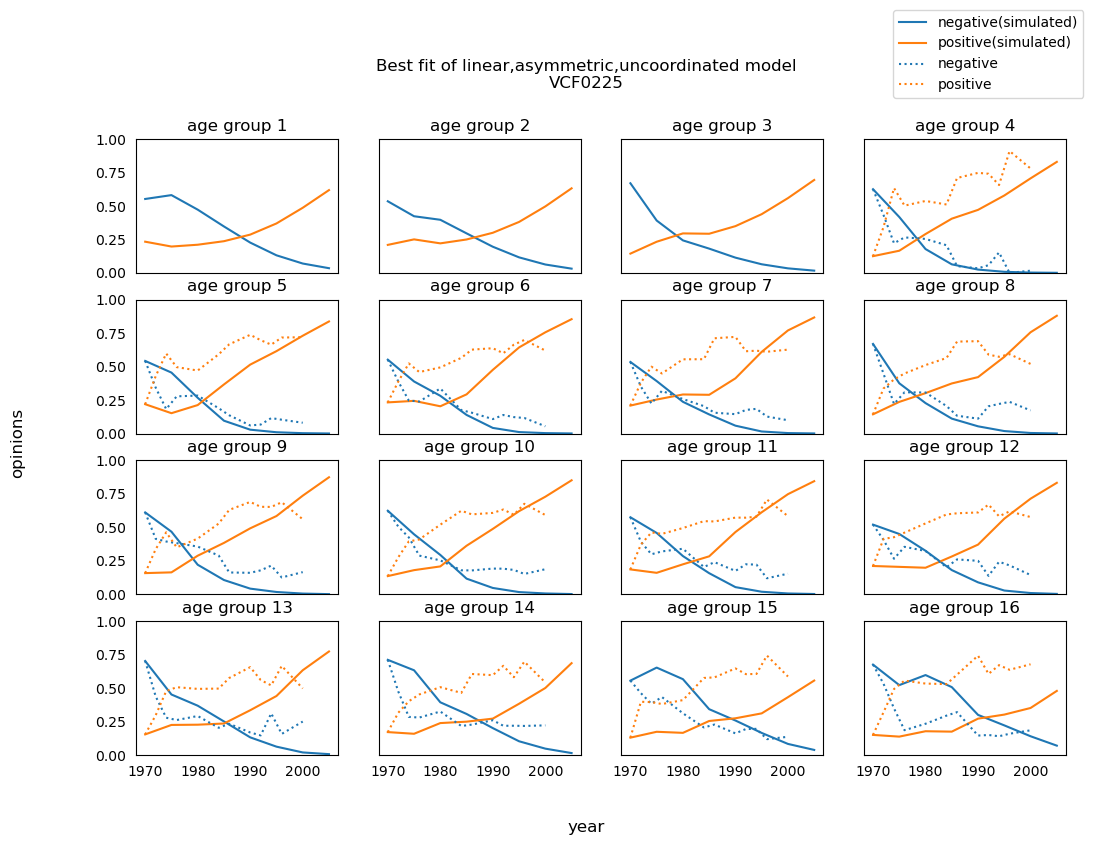

In [80]:
# Visualization
# find the optimal c and a, plot the comparison
BEL = lauopt[0]*np.ones(N) + lauopt[4]*np.arange(0,N)
GAL = lauopt[1]*np.ones(N) + lauopt[5]*np.arange(0,N)
BER = lauopt[2]*np.ones(N) + lauopt[6]*np.arange(0,N)
GAR = lauopt[3]*np.ones(N) + lauopt[7]*np.arange(0,N)
for j in range(1, N):
    if BEL[j]*sum(W[j,:]) > 1 or BER[j]*sum(W[j, :])>1 or GAL[j]*sum(W[j,:]) > 1 or GAR[j]*sum(W[j, :])>1:
        print('Warning')
pneg,pneu,ppos = simasym(BEL,BER,GAL,GAR)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,asymmetric,uncoordinated model\n' + varname)
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('thermodelweightedfits/'+'laufit'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [81]:
def AIC(k, N, SSE):
    return 2*k + N * math.log(SSE/N)

In [82]:
# number of data points
ndp = np.count_nonzero(~np.isnan(In[:,4,:]))
print(ndp)
aiccs = AIC(2, ndp, ssecs)
aiccas = AIC(4, ndp, ssecas)
aiclsc = AIC(3, ndp, sselsc)
aiclsu = AIC(4, ndp, sselsu)
aiclac = AIC(6, ndp, sselac)
aiclau = AIC(8, ndp, sselau)
print('AIC score of constant, symmetric model: ', round(aiccs,4))
print('AIC score of constant, asymmetric model: ', round(aiccas,4))
print('AIC score of linear, symmetric, coordinated model: ', round(aiclsc,4))
print('AIC score of linear, symmetric, uncoordinated model: ', round(aiclsu,4))
print('AIC score of linear, asymmetric, coordinated model: ', round(aiclac,4))
print('AIC score of linear, asymmetric, uncoordinated model: ', round(aiclau,4))
print('Best model is model', np.argmin([aiccs, aiccas, aiclsc, aiclsu, aiclac, aiclau])+1)

156
AIC score of constant, symmetric model:  -353.1952
AIC score of constant, asymmetric model:  -372.5342
AIC score of linear, symmetric, coordinated model:  -398.5094
AIC score of linear, symmetric, uncoordinated model:  -404.6367
AIC score of linear, asymmetric, coordinated model:  -392.5094
AIC score of linear, asymmetric, uncoordinated model:  -396.6367
Best model is model 4


In [83]:
print('Constant, symmetric model: ', round(ssecs,5), '\n', np.around(csopt,decimals=5))

print('Constant, asymmetric model: ', round(ssecas,5), '\n', np.around(casopt,decimals=5))

print('linear, symmetric, coordinated model: ', round(sselsc,5), '\n', np.around(lscopt,decimals=5))

print('linear, symmetric, uncoordinated model: ', round(sselsu,5), '\n', np.around(lsuopt,decimals=5))

print('linear, asymmetric, coordinated model: ', round(sselac,5), '\n', np.around(lacopt,decimals=5))

print('linear, asymmetric, uncoordinated model: ', round(sselau,5), '\n', np.around(lauopt,decimals=5))

Constant, symmetric model:  15.80211 
 [0.01492 0.01492]
Constant, asymmetric model:  13.60631 
 [0.0155  0.02078 0.01529 0.01976]
linear, symmetric, coordinated model:  11.66797 
 [0.02204 0.01993 0.00014]
linear, symmetric, uncoordinated model:  11.07565 
 [3.96e-02 2.14e-03 1.18e-03 8.00e-05]
linear, asymmetric, coordinated model:  11.66797 
 [0.02204 0.01993 0.00014 0.02204 0.01993 0.00014]
linear, asymmetric, uncoordinated model:  11.07565 
 [3.96e-02 2.14e-03 3.96e-02 2.14e-03 1.18e-03 8.00e-05 1.18e-03 8.00e-05]
